# Introduction

This notebook allows you to apply a simplified version of the ANTARESS workflow to a dataset obtained during an exoplanet transit, for the following purposes:
- characterizing systematic trends in out-of-transit stellar line properties 
- measuring the systemic velocity at the epoch of the transit

The notebook takes as input a time-series of disk-integrated CCFs, after they have been processed with the [reduction notebook](https://gitlab.unige.ch/spice_dune/antaress/-/blob/main/Notebooks/ANTARESS_nbook_sp_reduc.ipynb)). The default version is set up to analyze the echelle spectra obtained with ESPRESSO during the transit of TOI-421c, cleaned and converted into CCFs with the reduction notebook. Otherwise adjust settings to retrieve your own cleaned dataset, setting `working_path`, `star_name`, and `pl_name` to the same values that you used to [initialize](https://gitlab.unige.ch/spice_dune/antaress/-/blob/main/Notebooks/ANTARESS_nbook_setup.ipynb) your system.

To exploit the workflow to its full capabilities, run its executable with the [configuration files](https://obswww.unige.ch/~bourriev/antaress/doc/html/installation.html).

In [1]:
import ANTARESS_nbook_bground
input_nbook = {
    'working_path' : '/Users/bourrier/Travaux/ANTARESS/Working_dir/',
    'star_name' : 'TOI421',
    'pl_name'   : 'TOI421c'
}
input_nbook = ANTARESS_nbook_bground.load_nbook(input_nbook, 'Trends')

# CCF analysis

**Analysis**

Trends are searched for in the [series](#fit_prop) of disk-integrated stellar line properties.
The first step thus consists in fitting the CCF to derive these properties. 
ANTARESS sets up the fit automatically, but if need be you can:
- Define the radial velocity ranges used to fit the stellar line (`fit_range`), and covering its continuum (`cont_range`). Both ranges are defined as $[[rv_{\mathrm{low}, 1}, rv_{\mathrm{high}, 1}], [rv_{\mathrm{low}, 2}, rv_{\mathrm{high}, 2}],...]$, which allows combining non-consecutive regions. Radial velocities are in km/s in the star rest frame (i.e., relative to the systemic rv you [set up](https://gitlab.unige.ch/spice_dune/antaress/-/blob/main/Notebooks/ANTARESS_nbook_setup.ipynb) for the system). Use the [plots](#Plot_display) of the CCFs to inform your choice.
- Define guess values for the fitted line properties (full-width at half-maximum FWHM, in km/s; contrast; rv position in the solar barycentric rest frame, in km/s).

The fit is performed using a Gaussian line model with $\chi^2$-minimization. Additional line models and fit options are available through the configuration file. 

In [2]:
# Uncomment to define ranges
input_nbook['par'].update({
    'cont_range' : [[-100., -25.], [25., 100.]],
    'fit_range'  : [[-100, 100]]
})

# Uncomment to set guess values
input_nbook['par']['guess'] = {
    'rv'       : 0.,
    'FWHM'     : 6.,
    'ctrst'    : 0.7,
}

# Set to True to run the fit, and to False to retrieve its results
input_nbook['par']['calc_fit'] = True  #& False

ANTARESS_nbook_bground.ana_prof(input_nbook,'DI')

**Plotting**

Run this cell to plot the disk-integrated CCF series with their best fits. 

Use `x_range` to adjust the rv range of the profiles and `y_range` to adjust their flux range. Set to `None` for self-determination.

In [3]:
input_nbook['par']['x_range'] = [20.,140.] 
input_nbook['par']['y_range'] = [0.35,1.1] 
ANTARESS_nbook_bground.plot_prof(input_nbook,'DI_prof')

Plots are stored in the `/Working_dir/Star/Planet_Plots/DI_data/Instrument_Visit_Indiv/Data/` directory.

<a id='fit_prop'></a>
# Trend characterisation

**Analysis**

You can now search for correlations of the derived stellar line properties (contrast `contrast`, FWHM `FWHM`, and residuals from the Keplerian rv model `rv_res`) with orbital phase (`coord = 'phasePlanetName'`) and the spectra S/R (`coord = 'snr'`). Polynomial models are fitted to each property as a function of the chosen coordinate, over out-of-transit exposures.

Best-fit properties and merit values are printed in ANTARESS [run log](#Launch_ANTARESS). The goal is to find the coordinate and polynomial degree (`deg`) that yield the smallest Bayesian information criterion (BIC). Typical trends are a linear rv drift from the Keplerian over time, and a linear or quadratic correlation of the contrast with S/R. The FWHM is usually not precise enough to identify significant trends. 

The full workflow and its configuration file provide additional models and coordinates, and the possibility to combine multiple trends for a given property.

 
Identify any trends usinc the cell , and find the best model representing the data. Once the best models for the parameters RV, FWHM, and contrast have been found using the Bayesian Information Criterion, insert the coefficient for each model below. If multiple properties are being corrected, add them to the list as shown in the example below.


In [4]:
input_nbook['DI_trend'].update({
    'FWHM': {'deg' : 0.,'coord' : 'snr'},
    'contrast':{'deg' : 1.,'coord' : 'snr'},
    'rv_res':   {'deg' : 1.,'coord' : 'phaseTOI421c'},    
})

ANTARESS_nbook_bground.ana_jointprop(input_nbook,'DI')

**Systemic velocity**

The residual rv fitted with the trend model are calculated by subtracting the centroids of the disk-integrated lines, defined in the solar barycentric rest frame, and the Keplerian rv model based on your input [planet properties](https://gitlab.unige.ch/spice_dune/antaress/-/blob/main/Notebooks/ANTARESS_nbook_setup.ipynb) and systemic rv.

If this is your first run of the notebook, set the systemic rv `gamma` to 0 km/s. 
The zeroth-order coefficient of the residual rv fit will correspond to the systemic rv measured for your dataset, which you can then set `gamma` to.

In [5]:
input_nbook['par']['gamma'] = 79.403893
ANTARESS_nbook_bground.set_sysvel(input_nbook)

**Plotting disk-integrated line properties**

Run this cell to plot the time-series of properties derived from the fits to disk-integrated CCFs. 
Abscissa coordinate is automatically set to the fit coordinate.

Use `y_range` to adjust the property range (set to `None` for automatic determination).

In [6]:
input_nbook['par']['y_range'] = {
    'rv_res':      None, #[-4.,4.],  
    'contrast':    None, #[0.4,0.9],  
    'FWHM':        None, #[0.,6.]
}
ANTARESS_nbook_bground.plot_prop(input_nbook,'DI')

<a id='Launch_ANTARESS'></a>
# Running ANTARESS

Run this cell to run the ANTARESS workflow.

In [7]:
from antaress.ANTARESS_launch.ANTARESS_launcher import ANTARESS_launcher
ANTARESS_launcher(working_path=input_nbook['working_path'], nbook_dic = input_nbook, exec_comm=False)

****************************************
Launching ANTARESS
****************************************

Multi-threading: 16 threads available
Running with observational data
Study of: TOI421c
Accounting for Keplerian motion from all planets
Default nsub_Dpl[TOI421c]=26

-----------------------
Processing instrument : ESPRESSO
-----------------------
  Reading and initializing 2D echelle spectra
   > Errors propagated from raw data
   > Data processed on individual spectral tables for each exposure
         Retrieving data
         Processing visit 20231106
           Date (night start) : 2023/11/06
           Visit midpoint: 2460255.75606 BJD
           Exposures do not share a common spectral table
           54 exposures
   > Estimating instrumental calibration
         Retrieving data for 20231106
   > Correcting spectra for tellurics
         Retrieving data for 20231106
   > Calculating stellar masters
         Retrieving data for 20231106
   > Correcting spectra for global flux bal

<a id='Plot_display'></a>
# Plot display

In [8]:
from IPython.display import Image,display
from IPython.core.display import HTML 

**Disk-integrated CCFs**

This plot shows disk-integrated CCFs (blue profile) with their best-fit Gaussian model (dashed black profile), from which are derived the properties showed in the next plots. Blue shaded ranges hilight your selected continuum.

Choose the exposure to plot.

In [9]:
iexp2plot = 5

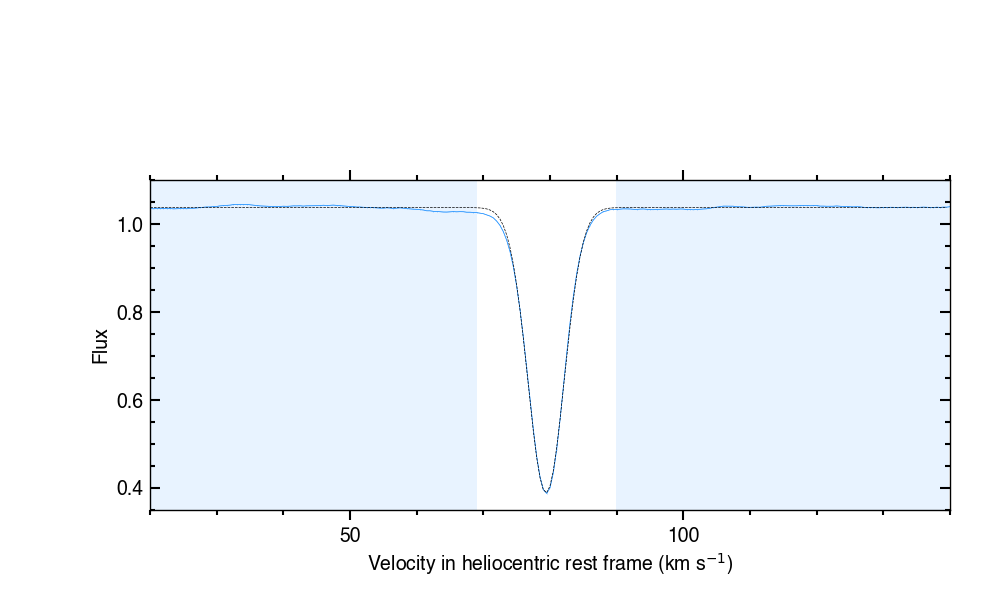

In [10]:
path = ANTARESS_nbook_bground.find_exp(iexp2plot, input_nbook['plot_path']+'DI_data/'+input_nbook['par']['instrument']+'_'+input_nbook['par']['night']+'_Indiv/Data/'+input_nbook['par']['type']+'/')
if path is not None:display(Image(filename = path))

**Disk-integrated line properties**

The four plots below show the time-series of rv and rv residuals, contrast, and FWHM derived from the fits to the disk-integrated CCFs. 
They are plotted as a function of their respective fit coordinate, with the best-fit polynomial model shown as a grey line.
If the coordinate is phase, transit contacts are shown as dashed black lines. In-transit exposures are flagged with empty symbols.

Outside of the transit, rv should trace the motion of the star with respect to the solar system barycenter (the Keplerian model defined by your inputs for the star and planets is plotted as a solid blue curve). If your star is quiet and measurements are dominated by white noise, rv residuals from the Keplerian model should be evenly spread around 0 m/s. Contrast and FWHM measurements should be evenly spread around their mean out-of-transit value (dashed blue lines). You can assess this by looking at the ratio between the dispersion and mean error over out-of-transit measurements, reported on each plot, which should be close to unity. If that is not the case, find the optimal detrending model.  

Inside of the transit the planet occults local regions of the stellar surface, distorting the disk-integrated stellar lines and inducing anomalous deviations in their derived properties. Traditionally, measurements of the sky-projected spin-orbit angle in planetary systems have been performed by analyzing this anomalous signal in RV - but the anomaly may not be detectable with faint, slow-rotating stars and small planets. With ANTARESS, you will be able to analyze directly the planet-occulted stellar profiles to get a higher precision on the transit chord and orbital architecture of the system.

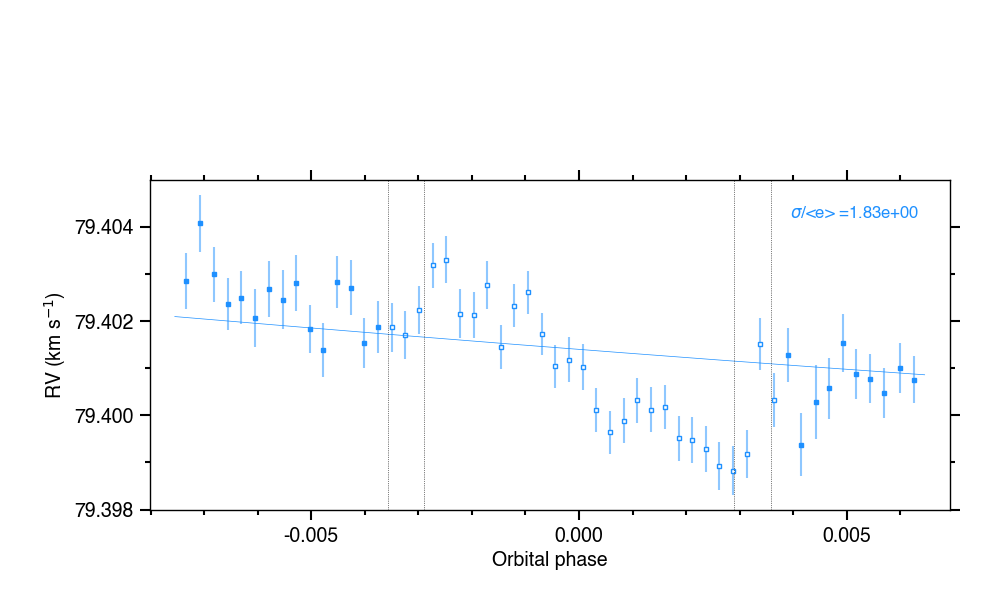

In [11]:
Image(filename = input_nbook['plot_path']+'DI_prop/rv_'+input_nbook['plots']['prop_DI_rv']['prop_DI_absc']+'.png')

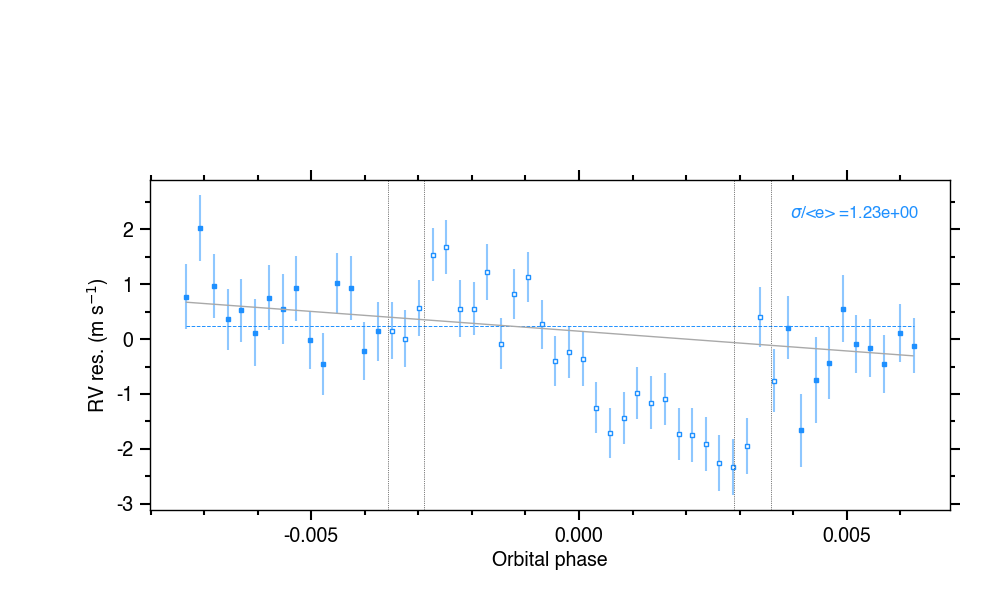

In [12]:
Image(filename = input_nbook['plot_path']+'DI_prop/rv_res_'+input_nbook['plots']['prop_DI_rv_res']['prop_DI_absc']+'.png')

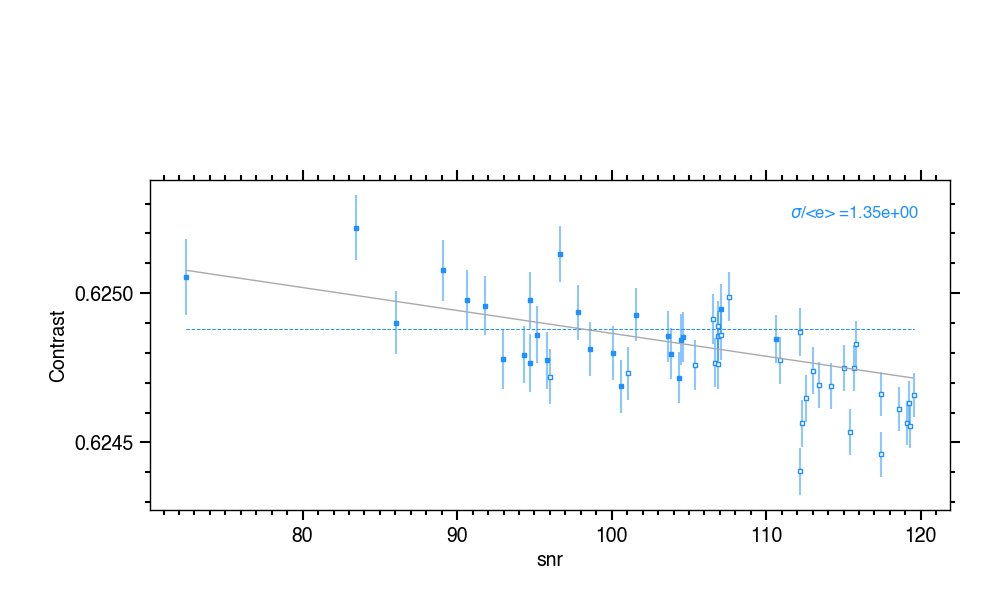

In [13]:
Image(filename = input_nbook['plot_path']+'DI_prop/ctrst_'+input_nbook['plots']['prop_DI_ctrst']['prop_DI_absc']+'.png')

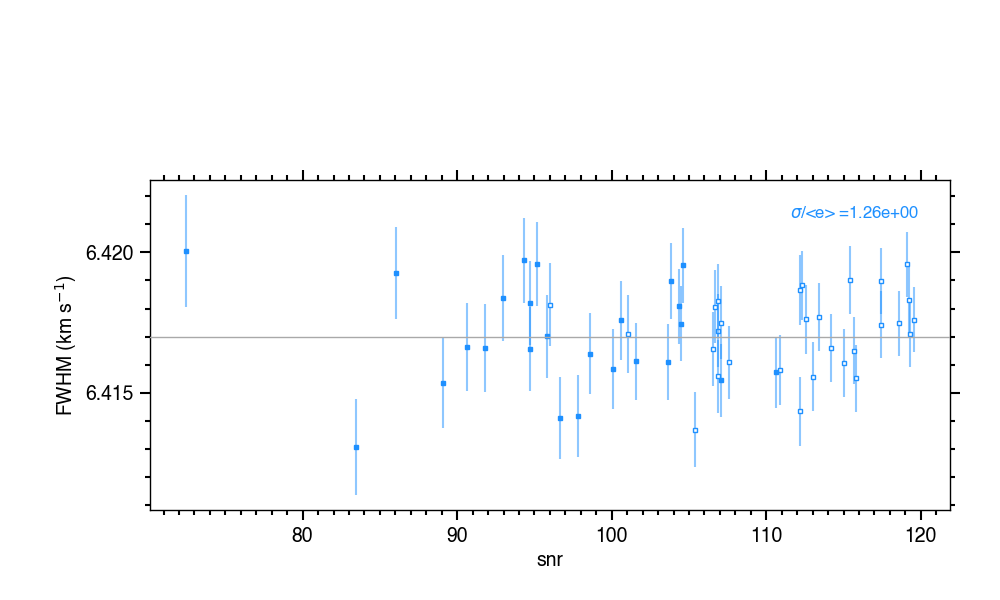

In [14]:
Image(filename = input_nbook['plot_path']+'DI_prop/FWHM_'+input_nbook['plots']['prop_DI_FWHM']['prop_DI_absc']+'.png')